# Prepare filelists for ISSAI TTS speakers 


In [1]:
import json 


def write_records_to_json(records, filename):
  """
  Writes a dictionary of records to a JSON file.

  Args:
    records: A dictionary where keys are speaker IDs and values are file paths.
    filename: The name of the JSON file to write to.
  """

  with open(filename, 'w') as f:
    json.dump(records, f)

def read_records_from_json(filename):
  """
  Reads a dictionary of records from a JSON file.

  Args:
    filename: The name of the JSON file to read from.

  Returns:
    A dictionary of records.
  """

  with open(filename, 'r') as f:
    return json.load(f)


speaker_metadata = read_records_from_json("../../../metadata/speaker_metadata.json")
speaker_metadata

{'F1': 'metadata/F1_manifest.csv',
 'F2': 'metadata/F2_manifest.csv',
 'F3': 'metadata/F3_manifest.csv',
 'M1': 'metadata/M1_manifest.csv',
 'M2': 'metadata/M2_manifest.csv'}

In [2]:
# See: https://github.com/espeak-ng/espeak-ng/blob/master/docs/languages.md
dir_data = "/home/temduck/vits2_unofficial/"
config = "../config.yaml"
symlink = "F1"
n_val = 100
n_test = 500

## Get hyperparameters from config file


In [3]:
import pandas as pd
from utils.hparams import get_hparams_from_file

hps = get_hparams_from_file(config)

## Read dataset

Here ISSAI dataset speakers 

In [4]:
speakers_datasets = {}
for speaker_id in speaker_metadata.keys():
    speakers_datasets[speaker_id] = pd.read_csv(dir_data+speaker_metadata[speaker_id],
                                                names=["file", "text"], header=0)

# EDA speakers text 

In [5]:
from tqdm import tqdm
from collections import defaultdict

def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character.lower()] += 1
    return charset


In [6]:
for speaker_id in speaker_metadata.keys():
    message = "character set count of {}, is {}".format(speaker_id, len(speaker_metadata[speaker_id]))
    print(message)

character set count of F1, is 24
character set count of F2, is 24
character set count of F3, is 24
character set count of M1, is 24
character set count of M2, is 24


In [6]:
import re
import string
from tqdm import tqdm
from text_utils import contains_non_kazakh_chars, normalize_text
tqdm.pandas()

speaker_metadata = read_records_from_json("../../../metadata/speaker_metadata.json")
speakers_datasets = {}
for speaker_id in speaker_metadata.keys():
    speakers_datasets[speaker_id] = pd.read_csv(dir_data+speaker_metadata[speaker_id],
                                                names=["file", "text"], header=0)

table = str.maketrans(dict.fromkeys('!"#$%&\'()*+/:;<=>?@[\\]^_`{|}~'))
for speaker_id in speaker_metadata.keys():
    speakers_datasets[speaker_id]["text"] = speakers_datasets[speaker_id]["text"].apply(normalize_text)
    speakers_datasets[speaker_id]["text"] = speakers_datasets[speaker_id]["text"].apply(lambda x: x.translate(table))
    speaker_metadata[speaker_id] = get_charset(speakers_datasets[speaker_id].to_dict(orient="records"))

# contains_other_lang = {}
# for speaker_id in speaker_metadata.keys():
#     mask = speakers_datasets[speaker_id]["contains_other_lang"]
#     contains_other_lang[speaker_id] = speakers_datasets[speaker_id][mask].copy(deep=True)
#     print(speaker_id, speakers_datasets[speaker_id]["contains_other_lang"].sum(), len(speaker_metadata[speaker_id]))
#     speaker_metadata[speaker_id] = get_charset(contains_other_lang[speaker_id].to_dict(orient="records"))
#     wrong_chars = {i: j for i, j in speaker_metadata[speaker_id].items() if contains_non_kazakh_chars(i)}
#     speaker_metadata[speaker_id] = wrong_chars
#     print(speaker_id, wrong_chars)

Computing character set: 100%|██████████| 32903/32903 [00:00<00:00, 59265.46it/s]


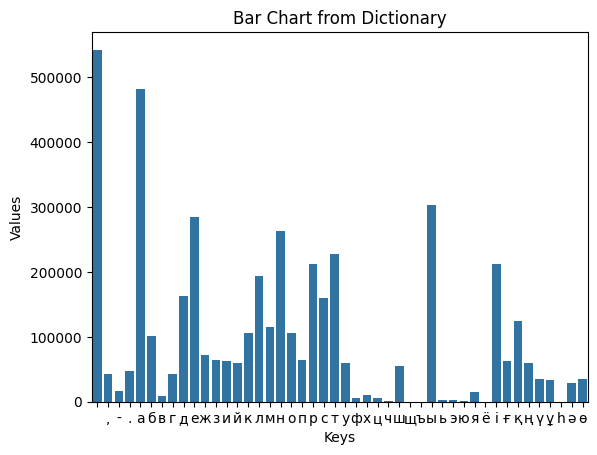

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(sorted(speaker_metadata["M1"].items()), columns=['Keys', 'Values'])
# Plotting
sns.barplot(x='Keys', y='Values', data=df)

# Adding title and labels
plt.title('Bar Chart from Dictionary')

# Display the plot
plt.show()

## Text cleaners

It may take a while, so better to preprocess the text and save it to a file in advance.

**Note** `phonemize_text` takes the longest time.`


In [7]:
# Get index of tokenize_text
text_cleaners = hps.data.text_cleaners

token_idx = text_cleaners.index("tokenize_text")
token_cleaners = text_cleaners[token_idx:]
print(token_cleaners)


# Extract phonemize_text
def separate_text_cleaners(text_cleaners):
    final_list = []
    temp_list = []

    for cleaner in text_cleaners:
        if cleaner == "phonemize_text":
            if temp_list:
                final_list.append(temp_list)
            final_list.append([cleaner])
            temp_list = []
        else:
            temp_list.append(cleaner)

    if temp_list:
        final_list.append(temp_list)

    return final_list


text_cleaners = text_cleaners[:token_idx]
text_cleaners = separate_text_cleaners(text_cleaners)
print(text_cleaners)

['tokenize_text', 'add_bos_eos']
[['phonemize_text'], ['add_spaces']]


In [11]:
for cleaners in text_cleaners:
    print(f"Cleaning with {cleaners} ...")

Cleaning with ['phonemize_text'] ...
Cleaning with ['add_spaces'] ...


In [8]:
from text import tokenizer
from torchtext.vocab import Vocab
import torchtext

torchtext.disable_torchtext_deprecation_warning()
speakers_datasets["F1"]["cleaned_text"] = speakers_datasets["F1"].text.progress_apply(lambda x: tokenizer(x, Vocab, ["phonemize_text", "add_spaces"], language=hps.data.language))

/home/temduck/anaconda3/envs/vits2/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/temduck/anaconda3/envs/vits2/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


TqdmKeyError: "Unknown argument(s): {'wokers': 4}"

In [11]:
from text import tokenizer
from torchtext.vocab import Vocab
import torchtext

torchtext.disable_torchtext_deprecation_warning()
data = speakers_datasets["F1"]
text_norm = data["text"].tolist()
for cleaners in text_cleaners:
    print(f"Cleaning with {cleaners} ...")
    # if cleaners[0] == "phonemize_text":
    #     text_norm = tokenizer(text_norm, Vocab, cleaners, language=hps.data.language)
    # else:
    #     for idx, text in enumerate(text_norm):
    #         temp = tokenizer(text, Vocab, cleaners, language=hps.data.language)
    #         text_norm[idx] = temp

data = data.assign(cleaned_text=text_norm)
data.head()

/tmp/ipykernel_1389/1164694482.py:6: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Cleaning with ['phonemize_text'] ...


## Generate and save vocabulary


In [6]:
from torchtext.vocab import build_vocab_from_iterator
from utils.task import load_vocab, save_vocab
from text.symbols import special_symbols, UNK_ID
from typing import List


def yield_tokens(cleaned_text: List[str]):
    for text in cleaned_text:
        yield text.split()


text_norm = data["cleaned_text"].tolist()
vocab = build_vocab_from_iterator(yield_tokens(text_norm), specials=special_symbols)
vocab.set_default_index(UNK_ID)

vocab_file = f"../vocab.txt"
save_vocab(vocab, vocab_file)

vocab = load_vocab(vocab_file)
print(f"Size of vocabulary: {len(vocab)}")
print(vocab.get_itos())

Size of vocabulary: 129
['<pad>', '<unk>', '<bos>', '<eos>', '<space>', '<laugh>', 'n', 't', 'ə', 's', 'd', 'ð', 'ɹ', 'k', 'z', 'ɪ', 'l', 'm', 'ˈɪ', 'p', 'w', 'v', 'ˈɛ', 'f', 'ˈeɪ', 'b', 'ɚ', ',', 'ʌ', 'ˈæ', 'h', 'ᵻ', 'i', 'æ', '.', 'ˈaɪ', 'ˈiː', 'ʃ', 'uː', 'ˈoʊ', 'ˈɑː', 'ˈʌ', 'ŋ', 'əl', 'ˈuː', 'ɾ', 'ɡ', 'ɐ', 'ˈɜː', 'dʒ', 'tʃ', 'iː', 'j', 'ˈaʊ', 'θ', 'ˌɪ', 'ˈɔː', 'ˈɔ', 'ˈoːɹ', 'ɔːɹ', 'ɛ', 'ˌɛ', 'ˌʌ', 'ˈɑːɹ', 'ˌæ', 'ˈɔːɹ', 'ˈʊ', 'ɜː', 'oʊ', 'eɪ', 'ˈɛɹ', 'ˈɪɹ', '"', 'ˌeɪ', 'iə', 'ʊ', 'ˌaɪ', 'ˈɔɪ', 'ˌɑː', ';', 'aɪ', 'ɛɹ', 'ˈʊɹ', 'ɑːɹ', 'ʒ', 'ˈaɪɚ', 'ˌiː', 'ˌuː', 'ˌoʊ', 'aʊ', 'ˈiə', 'ɑː', 'ɔː', 'n̩', 'ʔ', 'ˈaɪə', ':', 'oːɹ', 'ˌaʊ', 'ˌɑːɹ', 'ˌɜː', 'ˌoː', 'ˈoː', '?', 'ˌɔːɹ', 'ˌɔː', 'ɪɹ', 'ʊɹ', 'oː', '!', 'ɔɪ', 'ˌʊɹ', 'ˌʊ', 'ˌiə', 'ˌɔɪ', 'r', 'ɔ', 'ˌoːɹ', 'aɪə', 'ˌɪɹ', 'aɪɚ', 'ˌɔ', 'ˌɛɹ', 'x', '“', '”', 'ˈɚ', 'ˌaɪɚ', 'ˌn̩']


## Token cleaners


In [7]:
from text import detokenizer

text_norm = data["cleaned_text"].tolist()
for idx, text in enumerate(text_norm):
    temp = tokenizer(text, vocab, token_cleaners, language=hps.data.language)
    assert UNK_ID not in temp, f"Found unknown symbol:\n{text}\n{detokenizer(temp)}"
    text_norm[idx] = temp

text_norm = ["\t".join(map(str, text)) for text in text_norm]
data = data.assign(tokens=text_norm)
data.head()

,file,text,normalized_text,cleaned_text,tokens
0,DUMMY1/LJ001-0001.wav,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...","p ɹ ˈɪ n t ɪ ŋ , <space> ˈɪ n <space> ð ə <spa...",2\t19\t12\t18\t6\t7\t15\t42\t27\t4\t18\t6\t4\t...
1,DUMMY1/LJ001-0002.wav,in being comparatively modern.,in being comparatively modern.,ˈɪ n <space> b ˈiː ɪ ŋ <space> k ə m p ˈæ ɹ ə ...,2\t18\t6\t4\t25\t36\t15\t42\t4\t13\t8\t17\t19\...
2,DUMMY1/LJ001-0003.wav,For although the Chinese took impressions from...,For although the Chinese took impressions from...,f ɔːɹ <space> ɔː l ð ˈoʊ <space> ð ə <space> t...,2\t23\t59\t4\t92\t16\t11\t39\t4\t11\t8\t4\t50\...
3,DUMMY1/LJ001-0004.wav,"produced the block books, which were the immed...","produced the block books, which were the immed...",p ɹ ə d ˈuː s t <space> ð ə <space> b l ˈɑː k ...,2\t19\t12\t8\t10\t44\t9\t7\t4\t11\t8\t4\t25\t1...
4,DUMMY1/LJ001-0005.wav,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,ð ə <space> ɪ n v ˈɛ n ʃ ə n <space> ʌ v <spac...,2\t11\t8\t4\t15\t6\t21\t22\t6\t37\t8\t6\t4\t28...


## Save train, val, test filelists


In [8]:
data = data[["file", "tokens"]]
data = data.sample(frac=1).reset_index(drop=True)

data_train = data.iloc[n_val + n_test:]
data_val = data.iloc[:n_val]
data_test = data.iloc[n_val: n_val + n_test]

data_train.to_csv("../filelists/train.txt", sep="|", index=False, header=False)
data_val.to_csv("../filelists/val.txt", sep="|", index=False, header=False)
data_test.to_csv("../filelists/test.txt", sep="|", index=False, header=False)